# Make Sure You Are Ready to Go

$\renewcommand{\ket}[1]{\left| #1 \right\rangle}
\renewcommand{\bra}[1]{\left\langle #1 \right|}
\renewcommand{\braket}[2]{\left\langle #1 | #2 \right\rangle}
\newcommand{\ketbra}[2]{\left| #1 \right\rangle\!\left\langle #2 \right|}$

If you haven't done it yet, try running the following lines of code and use the [registration and installation](https://docs.classiq.io/latest/classiq_101/registration_installations/) page if you are having difficulty setting up your environment.\
Uncomment and run the following command to install or update to the latest version of the Classiq SDK (if not installed yet):

In [1]:
# pip install -U classiq
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import classiq

Uncomment and run the following command if your machine has not been authenticated yet, you only need to run it once!

In [3]:
# classiq.authenticate()

Now you are good to go!

# Rydberg Phase Diagram

Before starting to code, let us reiterating some theory on Rydberg atoms - the subject of this challenge. They interact via the following Hamiltonian:

$$
H = \frac{\Omega}{2} \sum_{i=1}^N X_i 
    - \delta \sum_{i=1}^N n_i 
    + \sum_{i \lt j} \frac{\Omega R_b^6 }{(a|i-j|)^6} n_i n_j.
$$

You can find the phase diagram for a $51$-atom chain below. It is obtained by fixing $a=1$ and $\Omega=1$ and varying $\delta$ and $R_b$.

<img src="phase_diagram.png" alt="Phase Diagram" width="800">


Fig.1: Phase diagram of the 1D Rydberg Hamiltonian, traced out by (left) bipartite entanglement entropy and (right) expectation value of the number of Rydberg excitations. Plots are obtained using tensor-network representation of the ground states of $H$.

In this challenge, we focus on distinguishing between the $Z2$ phase, where the ground state of $H$ has large overlap with the state $\ket{rgr\ldots gr}$, and the $Z3$ phase, where the ground state overlaps strongly with basis states of the form $\ket{\ldots rggrgg\ldots}$.

Evidently, such systems can be efficiently studied using tensor networks. However, this challenge prepares us for a more realistic scenario in which we only have access to measurement outcomes from the ground state of some Hamiltonian, and our goal is to determine which phase of matter the state belongs to.

# Loading and Processing Measurement Data

Training data for your model contains measurement results in randomized bases performed on a 51-qubit Rydberg atoms chain. We load training data from the .npz file in the next cell.

In [4]:
import numpy as np
# You might need to make additional imports depending on your implementation

In [5]:
loaded = np.load("training_data.npz", allow_pickle=True)

unprocessed_features = loaded["features"].tolist()
unprocessed_labels = loaded["labels"].tolist()

print(f'There are {len(unprocessed_features)} data points')
print(f'There were T = {len(unprocessed_features[0])} measurements performed for each data point')
print(f'The measurements were performed on {len(unprocessed_features[0][0])} qubits')
print(f'Example: 2nd experiment result of 8th data point -> {unprocessed_features[7][1]}')
print(f'Example: label for the 8th data point -> {unprocessed_labels[7]}')

There are 20 data points
There were T = 500 measurements performed for each data point
The measurements were performed on 51 qubits
Example: 2nd experiment result of 8th data point -> ['r', '-', 'i', 'i', 'r', '+', 'r', 'g', '+', '-i', 'r', '-', '-', 'g', '-i', '-', 'r', 'g', 'i', 'i', 'i', '-', 'r', '-i', 'r', 'i', 'r', '+', 'i', 'g', '-', '-i', '-', 'g', '-i', 'i', 'r', '-', '-', '-', 'i', 'i', '-i', 'g', '-i', 'g', 'r', '-', 'r', '+', '-']
Example: label for the 8th data point -> Z2


In the above,
- $\ket{g}$ is the atomic ground state, which is a $+1$-eigenstate of Pauli $Z$
- $\ket{r}$ is the highly excited Rydberg state, which is a $-1$-eigenstate of Pauli $Z$
- $\ket{+} = \frac{1}{\sqrt2}(\ket{g} + \ket{r})$, a $+1$-eigenstate of Pauli $X$
- $\ket{-} = \frac{1}{\sqrt2}(\ket{g} - \ket{r})$, a $-1$-eigenstate of Pauli $X$
- $\ket{+i} = \frac{1}{\sqrt2}(\ket{g} +i\ket{r})$, a $+1$-eigenstate of Pauli $Y$
- $\ket{-i} = \frac{1}{\sqrt2}(\ket{g} -i \ket{r})$, a $-1$-eigenstate of Pauli $Y$.

It is up to you how to convert the features into classical shadows and labels into numbers and then both into training data for your model. For example, you could assign $-1$ to $Z2$ and $+1$ to $Z3$.

**Note:** If you decide to define any helper classes/functions in a separate Python file, please submit it alongside your solution notebook, so we can run and grade it properly

## Dataset 

The `shadows.py` file contains the functions that process loaded measurement features and labels and create a dataset suitable for training.

The last argument of `create_dataset` is the size of a subsystem. Instead of obtaining tensor product of density matrices, we flatten each individual density matrix, complex conjugate the values and contatenate them into a vector. We extract these vectors along all the measurements provided and this way we are able to generate a substantial size of a data set. With that, we keep the vector size pretty small and thus reduce the number of qubits in the circuit that encodes and studies the data.

If, for example, the subsystem size is 4, each density matrix for a single atom / qubit is represented by 4 values. Total values will be 4x4 = 16 and with dense angle encoding, it will require only 8 qubits.


In [6]:
### Your Code Goes Here: ###
from shadows import create_dataset


data_x, data_y = create_dataset(loaded["features"], loaded["labels"], 4)

# Defining a Quantum Model

In this section, you will create a QML model for classifying the quantum phases. This will include 3 stages:
- First, you will need to decide on the data encoding scheme, i.e. loading numerical features you obtained above into the quantum circuit. 
- Then, you will need to come up with an ansatz - a parametrized quantum circuit, which will be optimized to perform classification. 
- Finally, to readout classical information from the quantum model, you will need to perform some sort of measurement on the resultant quantum state. Perhaps, you could extract an expectation value of some Pauli-string $P \in \{I, X, Y, Z\}^{\otimes N}$, so that $\langle P \rangle < b$ is interpreted as $Z2$ and  $\langle P \rangle > b$ is interpreted as $Z3$ for some decision boundary $b$. 

There are several approaches to QML in Classiq, linked below.

You may find the following guides useful:
- QML with Classiq: http://docs.classiq.io/latest/user-guide/read/qml_with_classiq_guide/
- Variational Model Example: https://github.com/Classiq/classiq-library/blob/main/algorithms/qaoa/maxcut/qaoa_max_cut.ipynb
- Hybrid QNN: https://docs.classiq.io/latest/explore/algorithms/qml/hybrid_qnn/hybrid_qnn_for_subset_majority/

Although the 2nd guide describes a hybrid model, **you may not implement a hybrid model**, the guide should only be used as a reference as to how to implement QML. 

**Warning**: Training using the Classiq PyTorch integration may take a prohibitive amount of time. Consider this when choosing an approach.

In [7]:
from classiq import *
from classiq.execution import *
# You might need to make additional imports depending on your implementation

In [8]:
# The following function signatures are only a template to get you started. You may, and should change them to suit your needs!

#Change these according to your implementation.

feature_length = len(data_x[0])
# num_qubits = int(np.log2(feature_length))
num_qubits = int(feature_length / 2)
num_weights = 2 * num_qubits - 1
print(feature_length, num_qubits, num_weights)


@qfunc
def encoding(feature: CArray[CReal, feature_length], wires: Output[QArray]) -> None: # your encoding scheme
    encode_on_bloch(feature, wires)

@qfunc
def ansatz(angles: CArray[CReal], wires: QArray) -> None: # your ansatz
    ### Your Code Goes Here: ###
    repeat(count=num_qubits, iteration=lambda i: RY(angles[i], wires[i]))
    repeat(count=num_qubits-1, iteration=lambda i: RZZ(angles[i+wires.len], wires[i:i+2]))
    # repeat(count=num_qubits, iteration=lambda i: RY(angles[i+wires.len], wires[i]))

    
@qfunc
def main(feature: CArray[CReal, feature_length], weights: CArray[CReal, num_weights], result: Output[QArray[QBit, num_qubits]]):
    '''
    Combine the encoding scheme and parametrized quantum circuit you came up with
    to encode and then process data
    '''
    # allocate(num_qubits, result)
    encoding(feature, result)
    ansatz(weights, result)



16 8 15


### Synthesis

Before training, you must synthesize your model into a quantum program. Placeholders for your parameters will be automatically generated.

You may find the following documentation useful: https://docs.classiq.io/latest/sdk-reference/synthesis/

In [9]:
# Set your preferences here!

NUM_SHOTS = 1024

# SIMULATOR is the default backend.
BACKEND_PREFERENCES = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR
)

# Vary this to achieve the best optimization of your circuit.
OPTIMIZATION_PARAMETER = 'depth' 

QMOD = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=NUM_SHOTS, backend_preferences=BACKEND_PREFERENCES
    ),
    constraints=Constraints(optimization_parameter=OPTIMIZATION_PARAMETER)
)
QPROG = synthesize(QMOD)

# Use the show() function to display your circuit in the browser.
# show(QPROG)

# Training the Model

Here, you will optimize the weights in ansatz, so that the model can distiguish between the phases. 

You can find the following Classiq tutorial and documentation useful: 
- Execution: https://docs.classiq.io/latest/sdk-reference/execution/ 
- Execution Session: https://docs.classiq.io/latest/user-guide/execution/ExecutionSession/
- Executing With Parameters: https://docs.classiq.io/latest/qmod-reference/language-reference/quantum-entry-point/

It is highly recommended to use an ExecutionSession if you are executing the same circuit with different parameters many times. It is not needed to train parameters using the Classiq PyTorch integration.

If you are not using the PyTorch integration, you will need an objective (also known as a 'loss', or 'cost') function. Depending on your implementation, you will need to either minimize or maximize it in training.

In [10]:
### Your Code Goes Here: ###
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.3, random_state=43, shuffle=True
)

`CircuitOptimizer` class will encapsulate the optimization process running batches of quantum estimation and iteratively training the parameter using the COBYLA optimizer.

In [12]:
OPTIMIZATION_ITERATIONS = 70

def params_initializer(count: int) -> list[float]:
    return [
        float(random.randint(0, 3000)) / 1000
        for _ in range(0, count)
    ]

def create_observable(n: int) -> list[PauliTerm]:
    def pauli_terms(site: int, total_sites: int):
        assert(0 <= site < total_sites)
        all_terms = []
        for pauli in [Pauli.X, Pauli.Y, Pauli.Z]:
            terms = [Pauli.I] * total_sites
            terms[site] = pauli
            terms[site+1] = pauli
            all_terms.append(terms)
        return all_terms

    return [
        PauliTerm(pauli=terms, coefficient=1) for i in range(n-1) for terms in pauli_terms(i, n)
    ]

class CircuitOptimizer():

    def __init__(self, qprog, obs, params_count: int, iterations: int=OPTIMIZATION_ITERATIONS):
        self.qprog = qprog
        self.observable = obs
        self.params_count = params_count
        self.session = ExecutionSession(qprog)
        self.iterations = iterations
        self.initializer = params_initializer
        self.optimization_progress = []

    def create_params(self, feature, weights):
        params = {"feature_" + str(i): x for i, x in enumerate(feature)}
        params.update({"weights_" + str(i): x for i, x in enumerate(weights)})
        return params

    def batch_estimation(self, params) -> float:
        results = self.session.batch_estimate(self.observable, params)
        return [r.value.real for r in results]

    def f(self, x, features, labels):
        loss = 0
        params = [self.create_params(feature, x) for feature in features]
        results = self.batch_estimation(params)
        for r, label in zip(results, labels):
            classification = 1 if r > 0 else 0
            loss += (classification - label) ** 2
        self.optimization_progress.append(loss)
        self.plot_progress()
        return loss
    
    def plot_progress(self):
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(self.optimization_progress, marker='o')
        plt.title("Loss Function Progress")
        plt.grid(True)
        plt.xlabel("Iteration")
        plt.show()

    def progress_callback(self, *args, **kwargs):
        pass

    def optimize(self, features, labels):
        random.seed(1001)
        self.optimization_progress = []
        out = minimize(
            self.f,
            x0=self.initializer(self.params_count),
            args=(features, labels),
            method="COBYLA",
            options={"maxiter": self.iterations},
            callback=self.progress_callback,
        )
        print(out)
        return out.fun, out.x


We will initialize `CircuitOptimizer` with the sybthesized Quantum model, observable and number of parameters to train. Circuit optimizer will randomly generate the initial vector of parameters and then will iteratively train them optimizing the loss function. The chosen observable represents the following Hamiltonian:

$H = \sum_{i=1}^{N-1}{\sigma^{i} \cdot \sigma^{i+1}}$

$\sigma^{i}=(\sigma_x^i, \sigma_y^i, \sigma_z^i)$ is the vector of Pauli operators at site $i$

In [13]:
circuit_optimizer = CircuitOptimizer(
    qprog=QPROG,
    obs=create_observable(num_qubits),
    params_count=num_weights
)

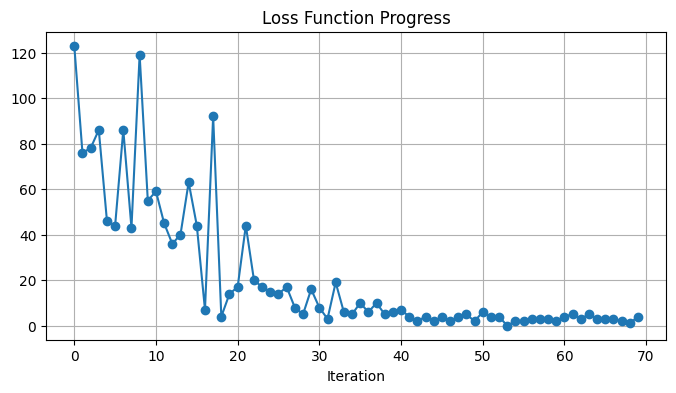

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.0
       x: [ 1.715e+00  8.503e-01 ...  6.472e-01  2.481e+00]
    nfev: 70
   maxcv: 0.0


In [14]:
loss, optimized_weights = circuit_optimizer.optimize(
    features=X_train,
    labels=y_train,
)

In [15]:
optimized_weights

array([ 1.71535801,  0.85033395, -0.22072182,  3.57723902,  2.5589642 ,
        0.36029534,  2.65209298,  2.23070398,  1.42676667,  2.13651474,
        2.67838176,  2.68649145,  2.52999606,  0.64717208,  2.48142688])

Training that takes too long may make it impossible to grade your submission.

# Testing the Model

Good job! Now it's time to see whether the model you designed can successfully perform the classification. For this, compare the predictions of your model to the actual labels. 

If the model does not perform well, try modifying the encoding and/or the ansatz (by using different number of parameters/qubits/ansatz layers/...)

In [16]:
### Your Code Goes Here: ###
def predict(features, weights):
    params = [circuit_optimizer.create_params(feature, weights) for feature in features]
    results = circuit_optimizer.batch_estimation(params)
    return [1 if r > 0 else 0 for r in results]

def calculate_accuracy(predictions, labels):
    correct = 0
    for p, l in zip(predictions, labels):
        if p == l:
            correct += 1
    return correct / len(labels)



In [17]:
A = calculate_accuracy(
    predict(X_test, optimized_weights),
    y_test
)
print(f"Accuracy: {A:.3f}")

Accuracy: 0.986


## Grading

You will be evaluated on the accuracy, depth, width of your model and the number of parameters in your model.

The following function will return the width and depth of your model as they will be used in grading. Use it to self-evaluate your model.

In [18]:
from classiq import QuantumProgram

def get_metrics(qprog):
    """
    Extract circuit metrics from a quantum program.

    Parameters:
        qprog: The quantum program object.

    Returns:
        dict: A dictionary containing the circuit metrics:
              - "depth": Circuit depth
              - "width": Circuit width
    """
    circuit = QuantumProgram.from_qprog(qprog)

    metrics = {
        "depth": circuit.transpiled_circuit.depth,
        "width": circuit.data.width,
    }

    return metrics

In [19]:
print(get_metrics(QPROG))

{'depth': 24, 'width': 8}


In [20]:
metrics = get_metrics(QPROG)
D = metrics["depth"]
W = metrics["width"]
P = len(optimized_weights)
grade = A * 100 - 0.1 * P - 0.0002 * D - 0.1 * W
print(f"Grade: {grade}")

Grade: 96.30631111111111


# Submission

You will submit this notebook, your trained parameters, and your quantum model. 

In [21]:
# Do not change this cell

import os

def save_qprog(qprog, team_name: str, folder="."):
    assert isinstance(team_name, str)
    file_name = f"{team_name.replace(' ','_')}.qprog"
    with open(os.path.join(folder, file_name), 'w') as f:
        f.write(qprog.model_dump_json(indent=4))
        
def save_params(params, team_name: str, folder="."):
    assert isinstance(team_name, str)
    file_name = f"{team_name.replace(' ','_')}.npz"
    with open(os.path.join(folder, file_name), 'wb') as f:
        np.savez(f, params=params)

In [22]:
# Change to your team name!!
TEAM_NAME = "quantotto"

# Insert your trained parameters here!
TRAINED_PARAMS = optimized_weights

save_qprog(QPROG, team_name=TEAM_NAME)
save_params(params=TRAINED_PARAMS, team_name=TEAM_NAME)

In [23]:
print("The END")

The END
